In [47]:
%matplotlib inline

import pandas as pd
import numpy as np
import pymc3 as pm
from pymc3.distributions import Interpolated
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import skew, kurtosis, norm, gaussian_kde
import math
from yahoo_fin.stock_info import get_data
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az


import matplotlib as mpl



import theano.tensor as tt

from pymc3 import Model, Normal, Slice, sample, traceplot

from theano import as_op

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [48]:
# Fund price data - not NAV
tickers = ['PGHN.SW', 'VDIGX', 'VQNPX', 'AAPL']
hist_prices = {}

for ticker in tickers:
    hist_prices[ticker] = get_data(ticker, start_date='01/01/2015', interval='1mo')

PG = hist_prices['PGHN.SW']
VDIGX = hist_prices['VDIGX']
VQNPX = hist_prices['VQNPX']
AAPL = hist_prices['AAPL']

In [49]:
# Compute returns - 1.) log 2.) Adj. log 3.) demean return
def returns(ticker):
    
    ticker['Adj Log Return'] = np.log(ticker['adjclose']).diff()
    ticker.index = pd.to_datetime(ticker.index)
    return ticker

VQNPX = returns(VQNPX)
PG = returns(PG)
AAPL = returns(AAPL)

In [50]:
AAPL.head()

,open,high,low,close,adjclose,volume,ticker,Adj Log Return
2015-01-01,27.847500,30.000000,26.157499,29.290001,26.681736,5221053600,AAPL,NaN
2015-02-01,29.512501,33.400002,29.020000,32.115002,29.255173,4546140800,AAPL,0.092077
2015-03-01,32.312500,32.570000,30.407499,31.107500,28.449223,4554568400,AAPL,-0.027936
2015-04-01,31.205000,33.634998,30.775000,31.287500,28.613842,3984542000,AAPL,0.005770
2015-05-01,31.525000,33.242500,30.840000,32.570000,29.786747,3816608400,AAPL,0.040173


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


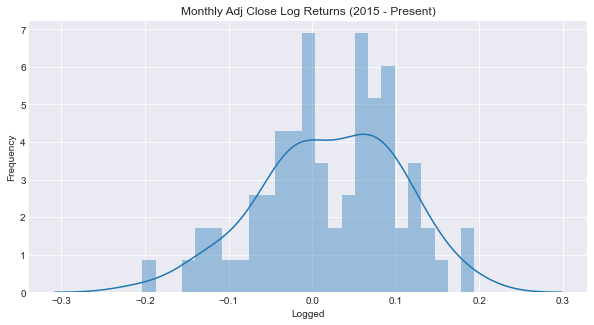

In [51]:
def distribution(ticker, date):
    
    plt.figure(figsize=(10,5))
    sns.distplot(ticker['Adj Log Return'], kde=True, bins=25)
    plt.title('Monthly Adj Close Log Returns ({} - Present)'.format(date))
    plt.xlabel('Logged')
    plt.ylabel('Frequency')
    
distribution(AAPL, '2015')

In [52]:
def descriptive_stats(ticker, sym):

    print("Skewness of {} = ".format(sym), round(ticker['Adj Log Return'].skew(), 2))
    print("Kurtosis of {} = ".format(sym), round(ticker['Adj Log Return'].kurtosis(), 2))
    print("Average monthly return of {} = ".format(sym), round(ticker['Adj Log Return'].mean(), 4))

#descriptive_stats(PG, 'PG')
descriptive_stats(AAPL, 'AAPL')

Skewness of AAPL =  -0.32
Kurtosis of AAPL =  -0.17
Average monthly return of AAPL =  0.0214


In [53]:
# Just curious to see the probability of monthly returns, on average, for the sample
def cdf(ticker):
    
    mu = np.mean(ticker['Adj Log Return'])
    std = np.std(ticker['Adj Log Return'])
    
    #Probability of having a good average monthly return: Pr(mu > #.#%)
    good_return = 1-(scipy.stats.norm.cdf(0.006, mu, std))
    print('The probability of having a good monthly return: Pr(mu > 0.6%) = ', round(good_return,2))

    neg_return = scipy.stats.norm.cdf(0.0, mu, std)
    print('The probability of having a negative monthly return: Pr(mu < 0.0%) = ', round(neg_return,2))
    
#cdf(PG)
cdf(AAPL)

The probability of having a good monthly return: Pr(mu > 0.6%) =  0.57
The probability of having a negative monthly return: Pr(mu < 0.0%) =  0.4


# **The four-step process in Bayesian analysis consists of:**

1. Modeling: Model parameters of interest as random variables, specify prior (density) functions and likelihood.
2. Updating: Update posterior (density) functions of parameters using data, priors, and likelihood.
3. Sampling: Generate samples from posterior (density) functions.
4. Inference: Summarize on parameters from posteriors samples using point or interval estimates

In [54]:
# The prior parameter inputs domain knowledge into prior probabilities
# I.e, Fund manager belief of negative average returns (and higher volatility)
def prior_params(ticker, mu, std):
    
    prior_params = {ticker: (mu, std)}
    
    return prior_params

prior_PG = prior_params('PG', 0.02, 0.075) 

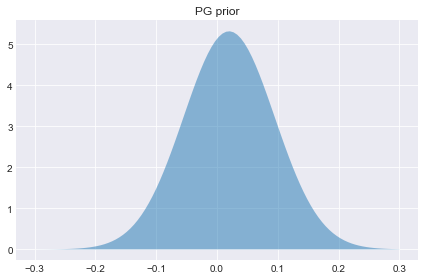

In [55]:
# Make this dynamic
x = np.linspace(-0.3, 0.3, 100)

for i, (name, params) in enumerate(prior_PG.items()):
    
    y = norm.pdf(x, params[0], scale=params[1])
    plt.fill_between(x, 0, y, linewidth=2, alpha=0.5)
    plt.title(name + ' prior')
    #plt.xlim(-0.25, 0.25)
    plt.tight_layout()

In [56]:
def timeframe(ticker, start, end):
    
    ticker = ticker[start : end]
    return ticker

AAPL_2018 = timeframe(AAPL, '2018', '2020')

In [57]:
AAPL_2018.tail()

,open,high,low,close,adjclose,volume,ticker,Adj Log Return
2020-08-01,108.199997,131.000000,107.892502,129.039993,128.585907,4070623100,AAPL,0.194233
2020-09-01,132.759995,137.979996,103.099998,115.809998,115.610542,3885767100,AAPL,-0.106370
2020-10-01,117.639999,125.389999,107.720001,108.860001,108.672516,2895016800,AAPL,-0.061888
2020-11-01,109.110001,121.989998,107.320000,119.050003,118.844963,2123077300,AAPL,0.089481
2020-12-01,121.010002,138.789993,120.010002,132.690002,132.690002,2322830600,AAPL,0.110196


In [71]:
def preprocessing(ticker):
    
    values = ticker['Adj Log Return'].values
    #demeaned = values - values.mean()
    values = values[np.logical_not(np.isnan(values))]
    return values
    
PG_returns = preprocessing(PG)
AAPL_returns = preprocessing(AAPL)

AAPL_2018_returns = preprocessing(AAPL_2018)

# Model Specification

In [59]:
# Obtaining my prior(s) and putting them in a list
def priors(params):
    
    prior_mu = np.array([x[0] for x in params.values()]) 
    prior_std = np.array([x[1] for x in params.values()])
    
    return prior_mu, prior_std

prior_PG_mu, prior_PG_std = priors(prior_PG)

In [60]:
# Model object is a container for the model's random variables (parameters of interest)
# This is our baseline model and does not include informative prior observations 
base = pm.Model()

with base:
    
    # Non-informative priors for unknown model parameters
    # Indicated by the values for mu and sigma
    mu = pm.Normal("mu", mu=0.0, sigma=0.01)
    tau = pm.Gamma("tau", mu=0.001, sigma=0.001)
    sigma = 1 / np.sqrt(tau)
    
    # Likelihood f(D|Θ)
    # Sampling distribution of observations
    # The mu and sigma should be unknown and not fixed values 
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=AAPL_returns)
    
    # Drawing 1000 posterior samples 
    trace = pm.sample(1000)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


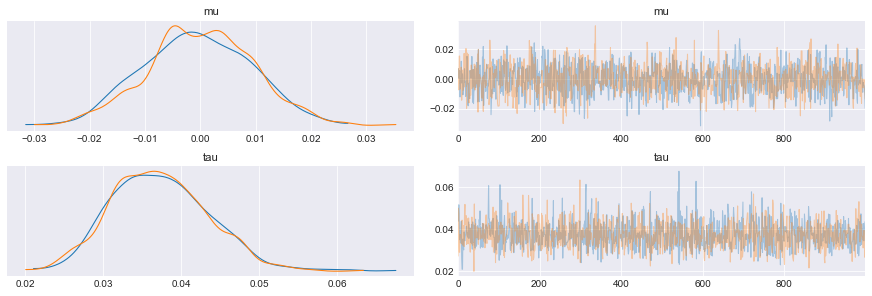

In [61]:
az.plot_trace(trace);

In [62]:
az.summary(trace)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.000,0.010,-0.018,0.017,0.0,0.0,1697.0,978.0,1699.0,1096.0,1.0
tau,0.037,0.006,0.027,0.049,0.0,0.0,1981.0,1979.0,1959.0,1498.0,1.0


Non-informative priors are specified for mu and sigma:
 - mu = Specified by a prior normal density function
 - tau = Inverse of variance and specified with Gamma prior density function
 - sigma = Derived by computing the inverse of tau 

Likelihood function is a normal density function with two params:
 - Average monthly return (mu)
 - Monthly standard deviation (sigma)

In [72]:
model = pm.Model()

with model:
    
    # Informative priors for unknown model parameters
    mu = pm.Normal("mu", mu=-0.025, sigma=0.02)
    #sigma = pm.HalfNormal("sigma", sigma=0.05)
    tau = pm.Gamma('precision', 15, 0.01)
    sigma = 1 / np.sqrt(tau)
    
    # Likelihood f(D|Θ) - Conditioning for unknown with the known (data)
    # The mu and sigma should be unknown and not fixed values 
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=AAPL_2018_returns)
    
    # Drawing 1000 posterior samples 
    trace = pm.sample(1000)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [precision, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'precision'}>,
        <AxesSubplot:title={'center':'precision'}>]], dtype=object)

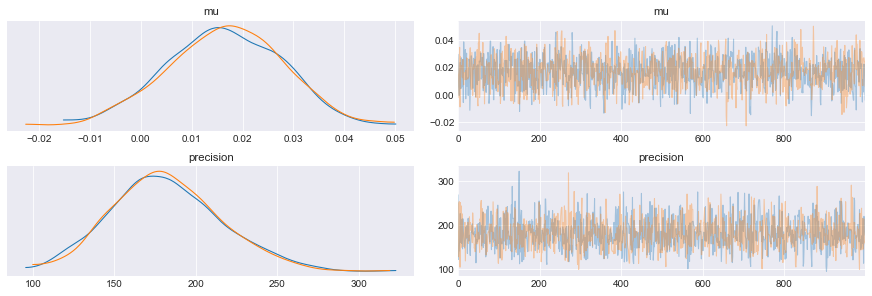

In [73]:
az.plot_trace(trace)

In [74]:
# Detailed summary of the posterior distribution for each parameter
az.summary(trace)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.016,0.011,-0.005,0.037,0.000,0.000,1607.0,1547.0,1609.0,1373.0,1.0
precision,181.996,33.472,122.099,246.743,0.842,0.597,1579.0,1574.0,1568.0,1208.0,1.0


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

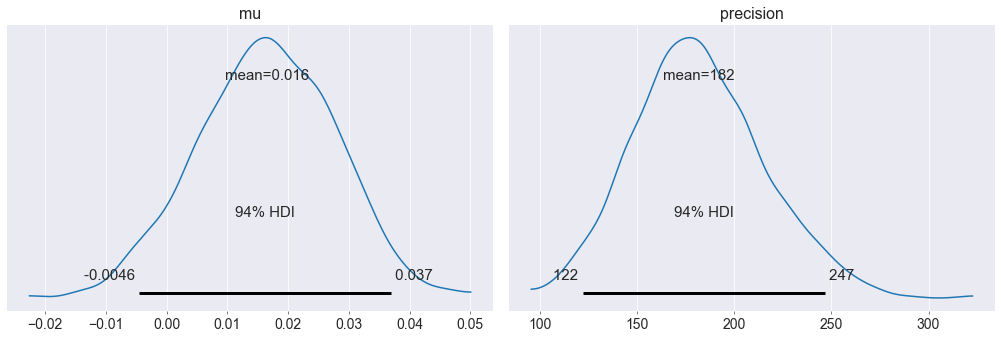

In [75]:
# HDI = There's a 94% probability the belief is between ## - ##
az.plot_posterior(trace)

In [76]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)

# 1000 = generated data sets
# 36 = 12 months in year, so 12 + 12 + 12 = 36, 36 months = our sample size
np.asarray(ppc['y']).shape

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


(1000, 36)

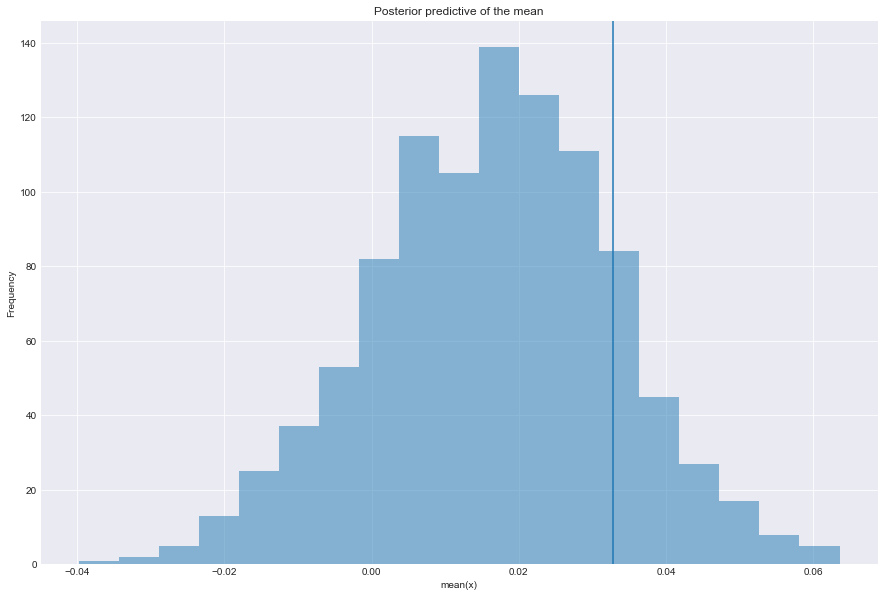

In [78]:
# Hindsight Bias - Plotting inferred mean (use of informative prior) vs actual mean
_, ax = plt.subplots(figsize=(15, 10))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(AAPL_2018['Adj Log Return'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

The inferred mean is NOT close to the actual return mean

# Model Fitting

 - Having specified our base model and model with informative priors, the next step is to use MCMC to sample and obtain posterior point and or interval estimates

In [ ]:
# Finding the MAP point for the original model
map_estimate = pm.find_MAP(model=base)
map_estimate

In [ ]:
# Sampling from posterior distribution - the parameter(s) of interest
with base:
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)
az.plot_trace(trace)